In [1]:
import os
import pandas as pd
from scipy.stats import mannwhitneyu
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [2]:
imgPath = '/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw'
sumPath = '/Volumes/genie/Jihong_GENIE_stuff/ufGCaMP_kinetics'

### Plot a sample trace

In [5]:
# imgFile = imgPath+'/2021.02.20_000/plate_001/patch_attempt_0017_000/I_clamp1_000/000/Camera/frames.ma'
# imgData = h5py.File(imgFile,'r')
# imgData = imgData['data'][()]
# print(imgData.shape)

In [7]:
# F = []
# for i in range(1900):
#     f = np.mean(imgData[i,234:274,:])
#     F.append(f)
# plt.plot(F)
# plt.show()


### Load summary file and add dFF to it

In [13]:
df = pd.read_excel(sumPath+'/summary.xlsx')
# df_new = pd.read_excel(sumPath+'/summary_new.xlsx') # Manually generate a summary file for each new session

In [9]:
def get_dff(trace,fb):
    f0 = np.mean(trace[50:150])
    df = trace-f0
    dff = df/(f0-fb)
    return dff

In [10]:
df_sel = df[:2]

2021.02.19_000 plate_000 patch_attempt_0000_001
2021.02.19_000 plate_000 patch_attempt_0002_000
2021.02.19_000 plate_000 patch_attempt_0003_000
2021.02.19_000 plate_000 patch_attempt_0005_000
2021.02.19_000 plate_000 patch_attempt_0006_000
2021.02.19_000 plate_000 patch_attempt_0009_000
2021.02.19_000 plate_000 patch_attempt_0011_000
2021.02.19_000 plate_001 patch_attempt_0013_000
2021.02.19_000 plate_002 patch_attempt_0034_000
2021.02.19_000 plate_002 patch_attempt_0037_000
2021.02.19_001 plate_001 patch_attempt_0017_000
2021.02.19_001 plate_001 patch_attempt_0021_000
2021.02.20_000 plate_000 patch_attempt_0001_000
2021.02.20_000 plate_000 patch_attempt_0005_000
2021.02.20_000 plate_001 patch_attempt_0009_000
2021.02.20_000 plate_001 patch_attempt_0013_000
2021.02.20_000 plate_001 patch_attempt_0015_000
2021.02.20_000 plate_001 patch_attempt_0016_000
2021.02.20_000 plate_001 patch_attempt_0017_000
2021.02.20_000 plate_001 patch_attempt_0018_000
2021.02.20_000 plate_001 patch_attempt_0

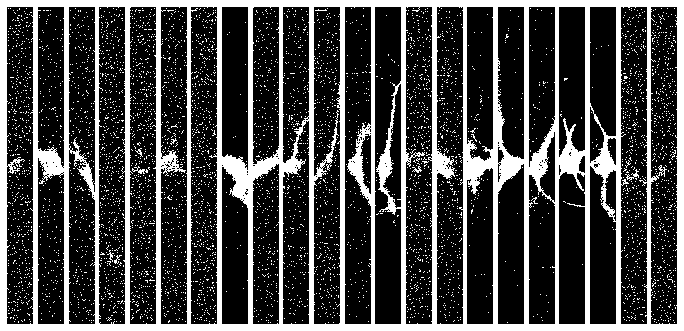

In [25]:
plt.figure(figsize=[12,10])
dFF_all = []
for i,r in df.iterrows():
    print(r['Date'],r['Plate'],r['Cell'])
    imgData = os.path.join(imgPath,r['Date'],r['Plate'],r['Cell'],'I_clamp1_000/000/Camera/frames.ma')
        
    imgData = h5py.File(imgData,'r')
    imgData = imgData['data'][()]
    
    p_val = []
    for row in range(imgData.shape[1]):
        for c in range(imgData.shape[2]):
            a = imgData[50:150,row,c]
            b = imgData[200:300,row,c]
            stat, p = mannwhitneyu(a, b, alternative='two-sided')
            p_val.append(p)
            
    p_val_2d = np.reshape(p_val,[imgData.shape[1],imgData.shape[2]])
    thre = sorted(p_val)[2000]
    mask = p_val_2d<thre
    ax = plt.subplot(1,22,i+1)
    ax.imshow(mask,cmap='gray')
    ax.axis('off')
  
    dff_single_cell = []
    for trial in range(10):
        
        imgData = os.path.join(imgPath,r['Date'],r['Plate'],r['Cell'],'I_clamp1_000',str(trial).zfill(3),'Camera/frames.ma')
        imgData = h5py.File(imgData,'r')
        imgData = imgData['data'][()]
        
        f_single_trial = []
        for frame in range(imgData.shape[0]):
            act_pix = imgData[frame,:,:]*mask
            f_single_frame = np.sum(act_pix)/np.sum(mask)
            f_single_trial.append(f_single_frame)
        imgMean = np.mean(imgData,axis=0)
        imgMean = imgMean.flatten()
        fb = sorted(imgMean)[int(imgMean.shape[0]*0.1)]
        dff_single_trial = get_dff(f_single_trial,fb)
        dff_single_cell.append(dff_single_trial[:1500])
    dFF_single_cell = np.mean(dff_single_cell,axis=0)
    dFF_all.append(dFF_single_cell)


# plt.tight_layout()
# plt.savefig(sumPath+'mask.png')
# plt.show()


In [26]:
df['dFF'] = dFF_all

In [56]:
ylim = (-0.036971130390316465, 0.37873168893709724)

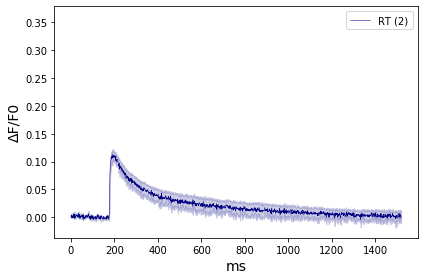

In [88]:
sensor = 500.456
# temps = ['RT',36]
temps = ['RT']
labels = {'RT':'RT',36:'36C'}

colors = {'RT':'navy',36:'r'}

x = np.arange(1500)*1.0135

for temp in temps:
    df_sel = df[(df['Mutation']==sensor)&(df['Temperature']==temp)]
    dff_mean = np.mean(df_sel.dFF.to_list(),axis=0)
    dff_sem = np.std(df_sel.dFF.to_list(),axis=0)/np.sqrt(len(df_sel))
    plt.plot(x,dff_mean,label=labels[temp]+' (%d)' %(len(df_sel)),color=colors[temp],lw=0.5)
    plt.fill_between(x,dff_mean+dff_sem,dff_mean-dff_sem,color=colors[temp],alpha=0.2)
plt.legend()
plt.ylim(ylim)
plt.xlabel('ms',size=14)
plt.ylabel('\u0394F/F0',size=14)
plt.tight_layout()
plt.savefig('/Users/zhengj10/Desktop/210224/456.png')
plt.show()


In [71]:
df

,Date,Plate,Mutation,Cell,Temperature,Power (%),Remark,dFF
0,2021.02.19_000,plate_000,10.921,patch_attempt_0000_001,36,10,NaN,"[0.007797039324023361, 0.0034908565103918794, ..."
1,2021.02.19_000,plate_000,10.921,patch_attempt_0002_000,36,10,NaN,"[0.004745428617226487, 0.002637500721405369, 0..."
2,2021.02.19_000,plate_000,10.921,patch_attempt_0003_000,36,20,NaN,"[0.013550934502406017, 0.004786931546110551, 0..."
3,2021.02.19_000,plate_000,10.921,patch_attempt_0005_000,36,20,NaN,"[0.002387204353772598, -0.00048517166259867716..."
4,2021.02.19_000,plate_000,10.921,patch_attempt_0006_000,RT,10,NaN,"[0.003649285401040025, -0.0005176723539796981,..."
5,2021.02.19_000,plate_000,10.921,patch_attempt_0009_000,RT,10,NaN,"[-0.0001558682074173768, 0.0011477048616809077..."
6,2021.02.19_000,plate_000,10.921,patch_attempt_0011_000,RT,10,NaN,"[0.005817736749695263, 0.006860567949921579, -..."
7,2021.02.19_000,plate_001,500.686,patch_attempt_0013_000,RT,20,NaN,"[0.005031663208810487, 0.0002720192565111955, ..."
8,2021.02.19_000,plate_002,500.688,patch_attempt_0034_000,RT,10,NaN,"[0.0195489286241239, -0.002398831935769916, -7..."
9,2021.02.19_000,plate_002,500.688,patch_attempt_0037_000,RT,10,NaN,"[0.014658003573177775, 0.011968537351128948, 0..."


In [90]:
df.to_pickle('/Users/zhengj10/Desktop/Recent data/ufGCaMP/summary.pkl')
df.to_excel('/Users/zhengj10/Desktop/Recent data/ufGCaMP/summary.xlsx')